In [3]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *
# from gridtools.hypnotoad_tools import *
# from gridtools.b2_tools import *
# from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Gridtools not found
Done


In [2]:
from gridtools.solps_python_scripts.read_b2fgmtry import *

# Hermes IO

In [4]:
casestore = dict()

In [5]:
db = CaseDB()

toload = [
    dict(name="1e19", id="d10d-anom_visc", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="2e19", id="d11b-d10d_2e19", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="3e19", id="d11c-d10d_3e19", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True)
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                           double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                           unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.942E+00 [m3]
CHECK: Total domain volume is 1.942E+00 [m3]


In [6]:
plt.close("all")
%matplotlib inline

In [9]:
write_file(casestore, r"C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl")

C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl written


## Read Hermes data

In [7]:
hr = dict()
for hermes_case in casestore.keys():
    print(hermes_case)
    hr[hermes_case] = Hermesdata()
    hr[hermes_case].read_case(casestore[hermes_case].ds.isel(t=-1, x = slice(2,-2)))

1e19
2e19


# Read SOLEDGE CSV data

In [8]:
soledgecases = {
    "nocurr_base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\nocurrents_baseline"), # Original case with hydrogen
    "nocore_d" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D"), # No ionising core BC, deuterium
    "tightwall" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\copy_wallMike_bra_nocore_D"),
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata()
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



In [24]:
path = soledgecases["nocore_d"]
sl["nocore_d"].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")

# Read SOLPS

In [9]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0")
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

## Plots

## Lineplots

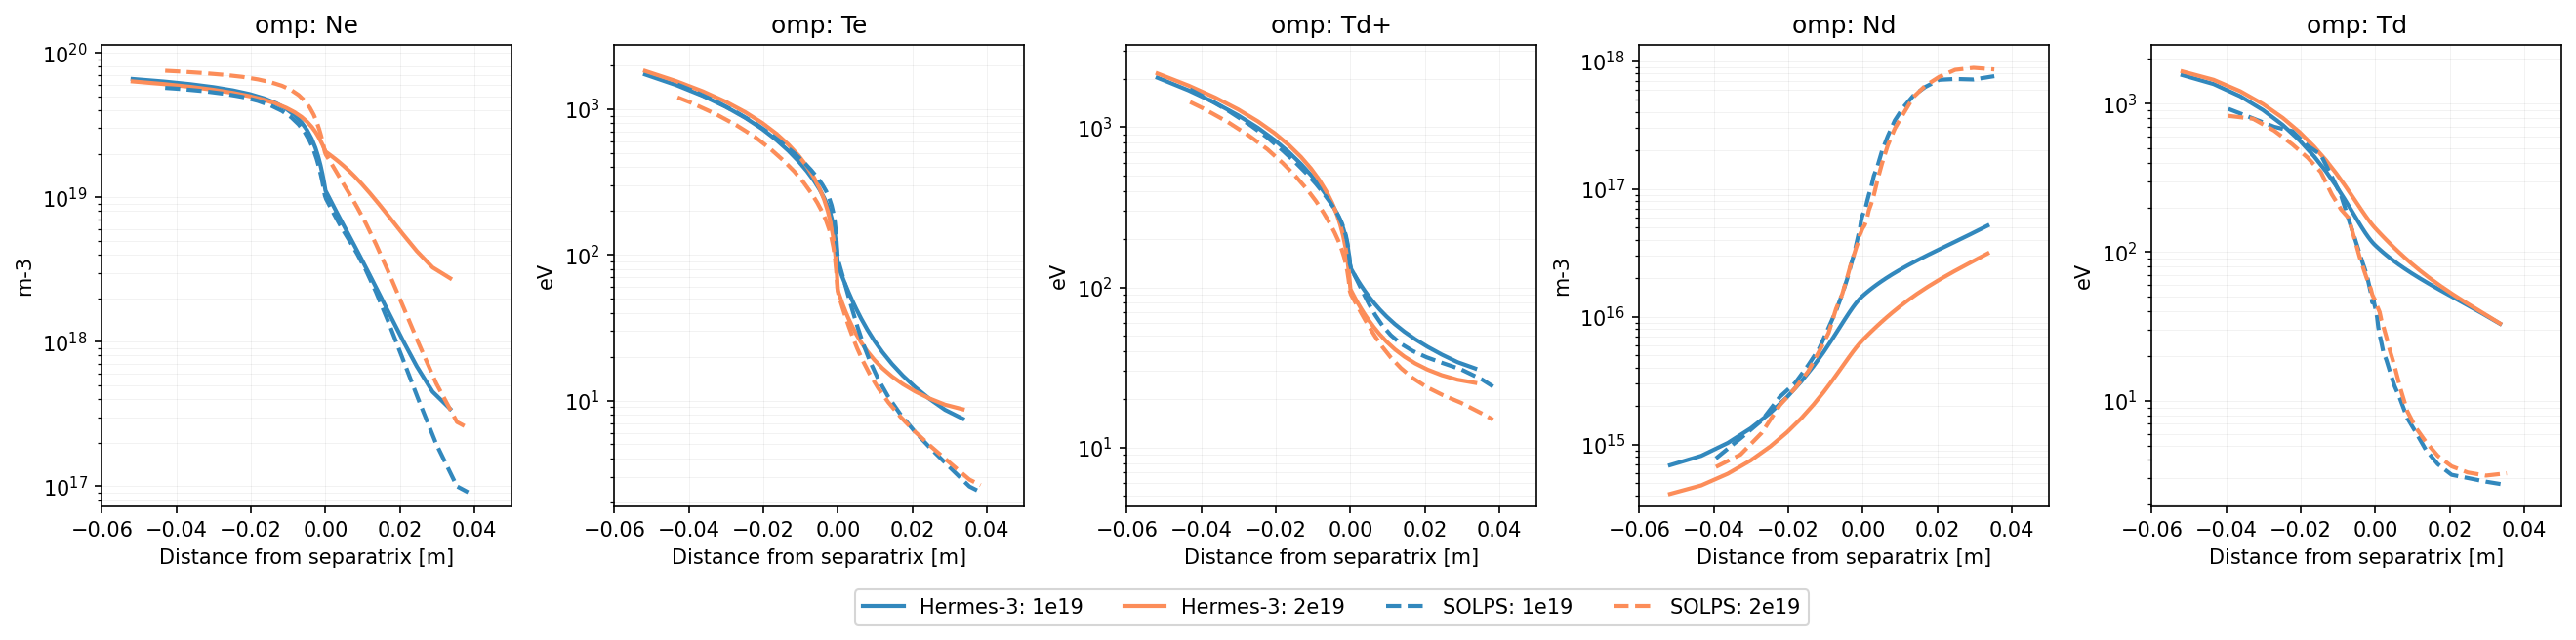

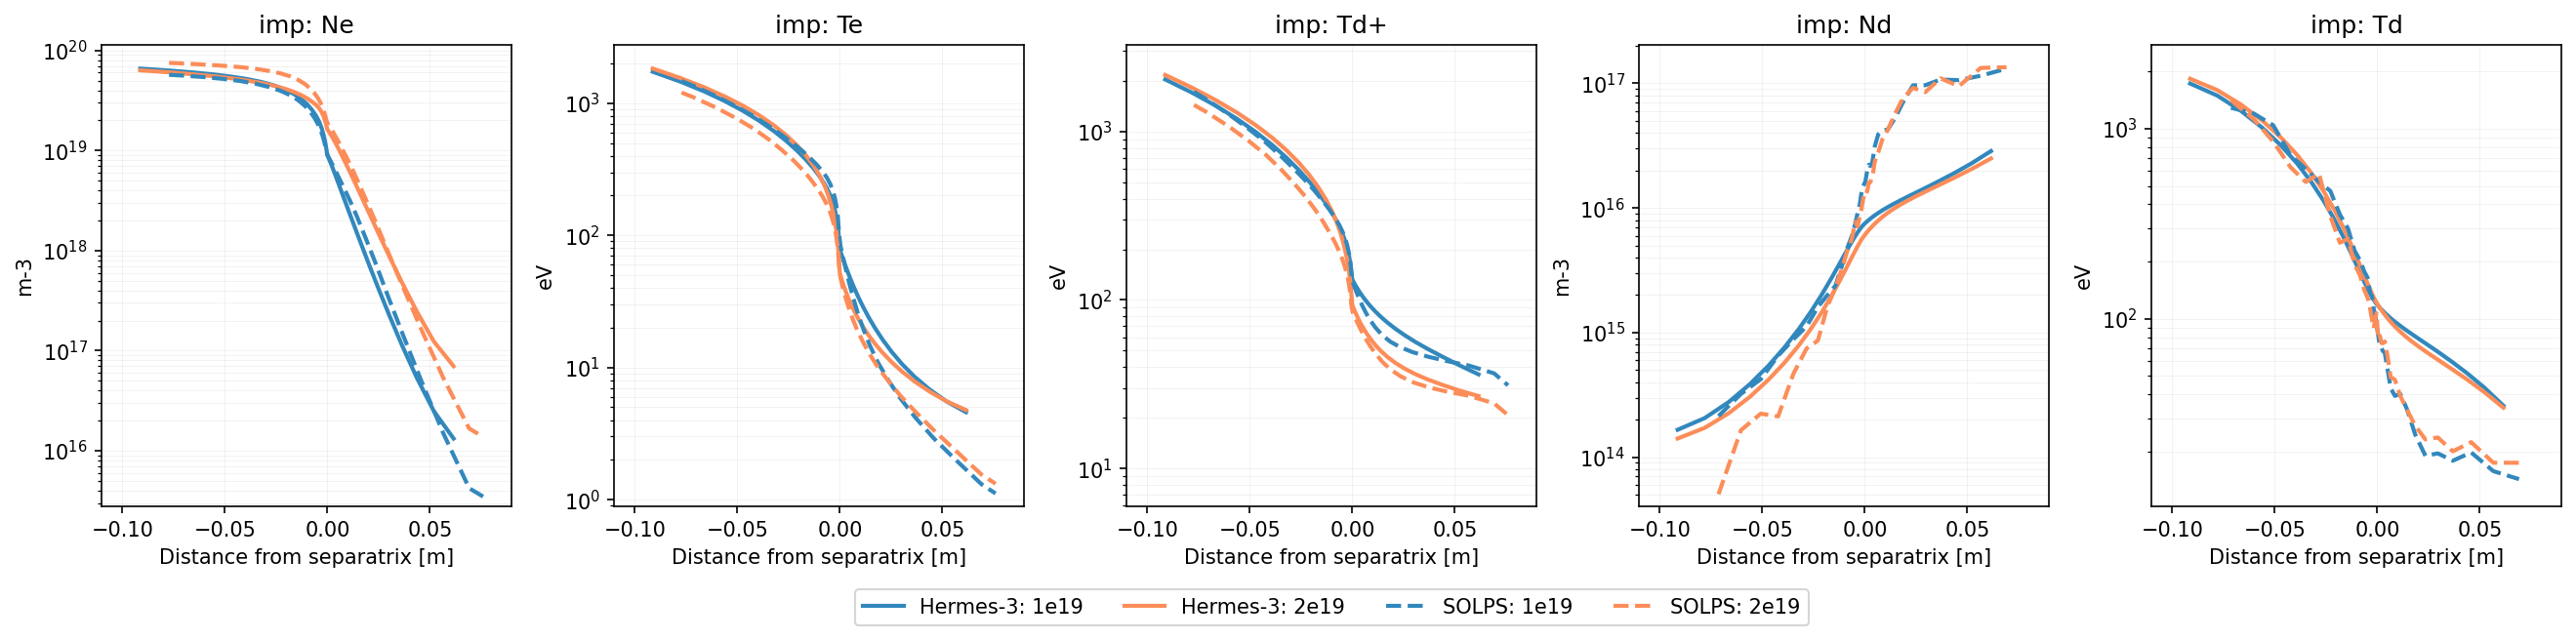

In [42]:

plt.close("all")
lineplot_compare(
    cases = { 
             
    "Hermes-3: 1e19": dict(data=hr["1e19"], color="#3288bd"),
    "Hermes-3: 2e19": dict(data=hr["2e19"], color="#fc8d59"),
    # "Hermes-3: 3e19": dict(data=hr["3e19"], color="#fc8d59"),
    
    "SOLPS: 1e19" : dict(data=sp["no_visc"], color="#3288bd"),
    "SOLPS: 2e19" : dict(data=sp["nsep_2e19"], color="#fc8d59"),
    # "SOLPS: 3e19" : dict(data=sp["nsep_3e19"], color="#fc8d59"),
    
    # "Hermes-3: Tn_sol=30eV" : dict(data=hr["tn30"], color="teal"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03_nonsepfit"], color="darkorange"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03"], color="darkorange"),
    
    },
    # regions = ["omp", "imp"], params = ["Ne", "Td+", "Te"],
    # regions = ["omp", "imp"], params = ["Nd", "Td", "Sd+_iz"],
    regions = ["omp", "imp"], params = ["Ne", "Te", "Td+", "Nd", "Td"],
    # regions = ["omp", "imp", "outer_lower"], params = ["Nd", "Td"],
    # regions = ["omp"], params = []
    mode = "log",
    dpi = 150,
    lw = 2
)

## 2D plots

['Densi', 'Tempi', 'velocityi', 'IRadi', 'NRadi', 'Sni', 'SEi', 'SGi', 'Nni', 'Tni', 'vxni', 'vyni', 'vzni', 'Nmi', 'Tmi', 'Pni', 'vxmi', 'vymi', 'vzmi', 'Ntii', 'Pni', 'TotRadi', 'Mi', 'Ppi', 'Epi', 'TDensi', 'TDensei', 'FracDensi', 'Cimpi', 'FracDensei', 'Zavei']
SOLEDGE: Combining Nmi and Nni


c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


b2fgmtry loaded from .pkl


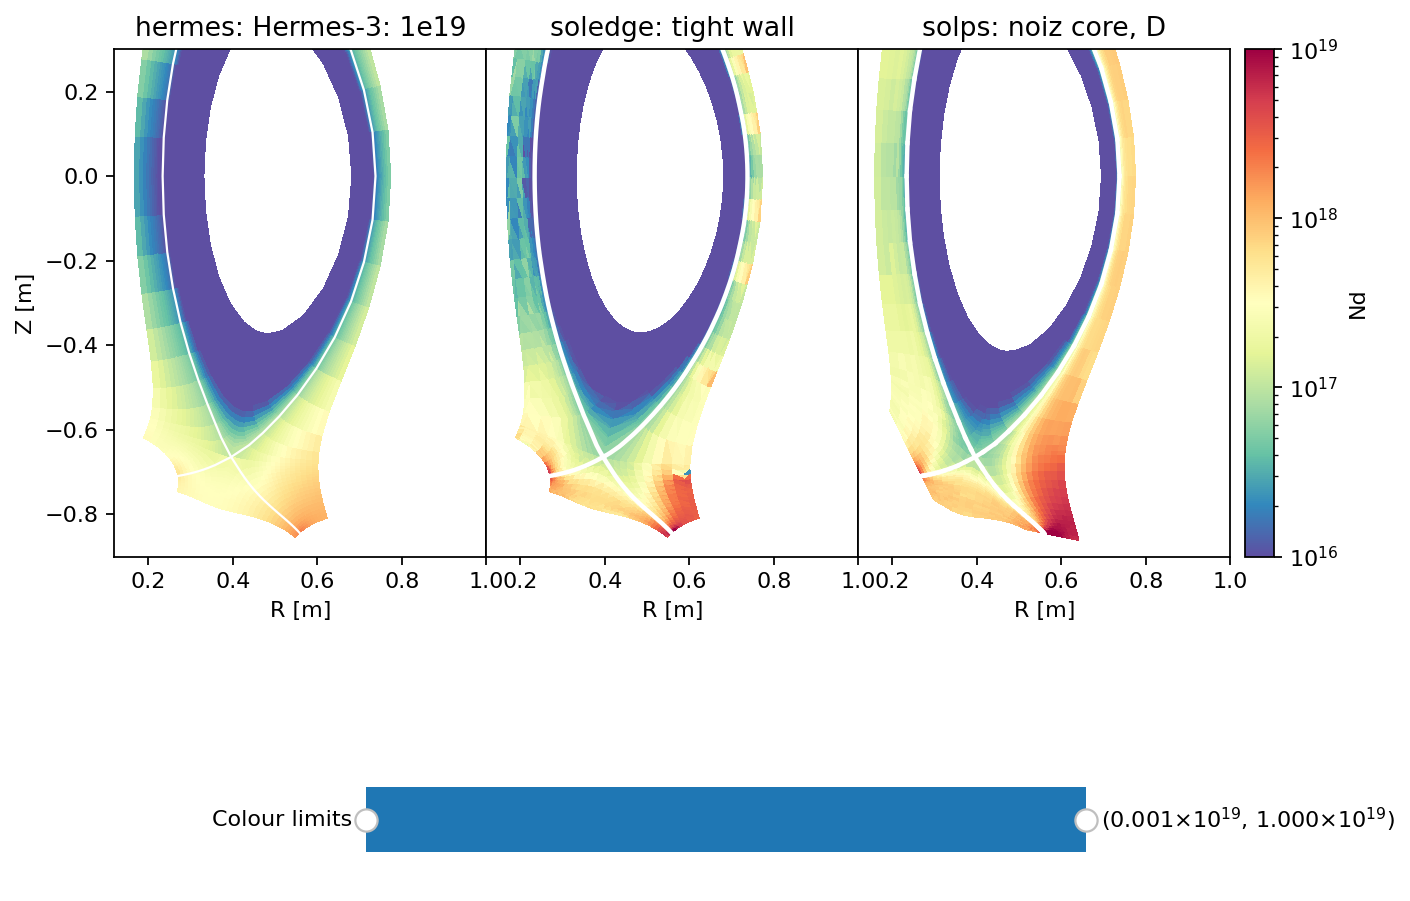

In [28]:
v = viewer_2d(
    "Nd",
    [
        {"name" : "Hermes-3: 1e19", "code" : "hermes", "ds" : casestore["1e19"].ds.isel(t=-1)},
        {"name" : "tight wall", "code":"soledge", "path" : soledgecases["tightwall"]},
        {"name": "noiz core, D", "code":"solps", "path" : solpscases['no_visc']}
    ],
    logscale = True,
    # vmin = 10,
    # vmax = 100,
    vmin = 1e16,
    vmax = 1e19,
    dpi = 160,
    ylim = (-0.9,0.3),
    xlim = (0.12, 1.0),
    wspace = 0.0,
    cmap = "Spectral_r"
)

In [ ]:
from code_comparison.solps_pp import *
params = ["Ne"]


self = SOLPScase(solpscases["nsep_2e19"])

region = "outer"
dist_from_sep = 0.001

if "outer" in region:
    radial_locator = self.s["omp"]
elif "inner" in region:
    radial_locator = self.s["imp"]
else:
    raise Exception(f"Region {region} not recognised")

p = radial_locator
radial_dist = self.g["R"][p[0], p[1]] - self.g["R"][p[0], self.g["sep"]] 
ring_index = np.argmin(abs(dist_from_sep - radial_dist))
ring_from_sep = ring_index - self.g["sep"]
print(f"Distance {dist_from_sep} corresponds to SOL ring {ring_from_sep}")    

# Get slice of the separatrix for the requested region
p = self.s[region]
p[1] += ring_from_sep   # Advance to desired SOL ring

poloidal_dist = 

dpi = 150
fig, axes = plt.subplots(2,len(params), dpi = dpi, figsize = (4.2*len(params),5), sharex = True)
fig.subplots_adjust(hspace = 0, wspace = 0.25, bottom = 0.25, left = 0.1, right = 0.9)

ax = axes[0]
ax.plot(dist, self.bal["ne"][:][p[0], p[1]])

In [61]:
for name in casestore:
    casestore[name].ds = calculate_radial_fluxes(casestore[name].ds)

# Part 1: Initial investigation

## Extracting pressure gradient

In [62]:
sdata = sp['nsep_2e19'].regions["omp"]
dist = sdata.index[1:-1] 
sPa = sdata["pab23da"].iloc[1:-1]
sPa_fun = scipy.interpolate.CubicSpline(dist, sPa)
Te = sdata["te3da"].iloc[1:-1].values
Ne = sdata["ne3da"].iloc[1:-1].values
Na = sdata["dab23da"].iloc[1:-1].values
Ta = sdata["tab23da"].iloc[1:-1].values   # Atoms
Ti = sdata["ti3da"].iloc[1:-1].values   # Atoms
Pa = sdata["pab23da"].iloc[1:-1].values

sPa_smooth = smooth(sPa,1, recursion=3)
Na_smooth = smooth(Na, 1, recursion=3)
Ta_smooth = smooth(Ta, 0.5, recursion=3)
sPa_fromsmoothed = Na_smooth * Ta_smooth * constants("q_e") * 3/2
sPa_calc = Na * Ta * constants("q_e") * 3/2
grad_sPa = np.gradient(dist, sPa)
grad_sPa_smooth = np.gradient(sPa_smooth, dist)

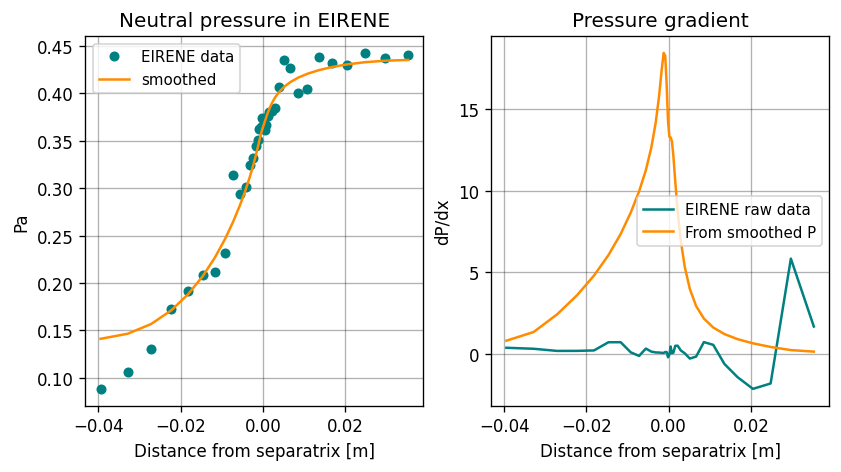

In [56]:
from sd1d.analysis import AMJUEL
rtools = AMJUEL()

def smooth(x,w,recursion=0):
    out = scipy.ndimage.gaussian_filter(x, w)
    for i in range(recursion):
        out = scipy.ndimage.gaussian_filter(out, w)
    return out

fig, axes = plt.subplots(1,2, figsize=(8,4), dpi = 120)

sdata = sp['nsep_2e19'].regions["omp"]
dist = sdata.index[1:-1]
sPa = sdata["pab23da"].iloc[1:-1]
sPa_fun = scipy.interpolate.CubicSpline(dist, sPa)

sPa_smooth = smooth(sPa,1.7, recursion=3)
# sPa_smooth = smooth(sPa,0.8, recursion=3)
grad_sPa = np.gradient(dist, sPa)
grad_sPa_smooth = np.gradient(sPa_smooth, dist)



axes[0].plot(dist, sPa, color = "teal", lw = 0, marker = "o", ms = 5, label = "EIRENE data")
axes[0].plot(dist, sPa_smooth, color = "darkorange", label = "smoothed")
axes[0].set_ylabel("Pa")
axes[0].set_title("Neutral pressure in EIRENE")
axes[1].plot(dist, grad_sPa, color = "teal", label = "EIRENE raw data")
axes[1].plot(dist, grad_sPa_smooth, color = "darkorange", label = "From smoothed P")
axes[1].set_ylabel("dP/dx")
axes[1].set_title("Pressure gradient")


for ax in  axes:
    ax.set_xlabel("Distance from separatrix [m]")
    ax.grid(color = "k", alpha = 0.3)
    ax.legend(fontsize=9)

### Treating density and temperature separately

In [ ]:
from sd1d.analysis import AMJUEL
rtools = AMJUEL()

def smooth(x,w,recursion=0):
    out = scipy.ndimage.gaussian_filter(x, w)
    for i in range(recursion):
        out = scipy.ndimage.gaussian_filter(out, w)
    return out

fig, axes = plt.subplots(1,4, figsize=(16,4), dpi = 120)



axes[0].plot(dist, Na, color = "teal", lw = 0, marker = "o", ms = 5, label = "EIRENE data")
axes[0].plot(dist, Na_smooth, color = "darkorange", label = "smoothed")
axes[0].set_ylabel("Pa")
axes[0].set_title("Neutral density in EIRENE")

axes[1].plot(dist, Ta, color = "teal", lw = 0, marker = "o", ms = 5, label = "EIRENE data")
axes[1].plot(dist, Ta_smooth, color = "darkorange", label = "smoothed")
axes[1].set_ylabel("Pa")
axes[1].set_title("Neutral temperature in EIRENE")

axes[2].plot(dist, sPa, color = "teal", lw = 0, marker = "o", ms = 5, label = "EIRENE data")
axes[2].plot(dist, sPa_smooth, color = "darkorange", label = "smoothed")
axes[2].plot(dist, sPa_fromsmoothed, color = "firebrick", label = "From smoothed Na, Ta")
# axes[2].plot(dist, sPa_calc, color = "firebrick", lw = 0, marker = "o", ms = 5, label = "Na * Ta")
axes[2].set_ylabel("Pa")
axes[2].set_title("Neutral pressure in EIRENE")
axes[3].plot(dist, grad_sPa, color = "teal", label = "EIRENE raw data")
axes[3].plot(dist, grad_sPa_smooth, color = "darkorange", label = "From smoothed P")
axes[3].set_ylabel("dP/dx")
axes[3].set_title("Pressure gradient")


for ax in  axes:
    ax.set_xlabel("Distance from separatrix [m]")
    ax.grid(color = "k", alpha = 0.3)
    ax.legend(fontsize=9)

## Capturing collisions

In [149]:
constants("q_e")

1.60217662e-19

## Make collisions

In [57]:
def coll_nn_sd1d(Ta, Na):
    vth_a = np.sqrt(constants("q_e") * (Ta)/(constants("mass_p")*2))   # Atom sound speed
    a0 = np.pi * 5.29e-11**2
    lambda_nn = 1/(Na*a0)
    for i, _ in enumerate(lambda_nn):
        if lambda_nn[i] > 0.1:
            lambda_nn[i] = 0.1
    nu_nn = vth_a / lambda_nn
    return nu_nn

# def coll_nn_


Kcx = [rtools.amjuel_1d("H.2 3.1.8", x) for x in Te]
nu_iz = np.zeros_like(Ta)
nu_cx = np.zeros_like(Ta)

for i, _ in enumerate(dist):
    nu_iz[i] = rtools.amjuel_2d("H.4 2.1.5", Te[i], Ne[i]) * Ne[i]
    nu_cx[i] = rtools.amjuel_1d("H.2 3.1.8", Te[i]) * Ne[i]

In [81]:
np.pi * (2.8e-10)**2

2.463008640414398e-19

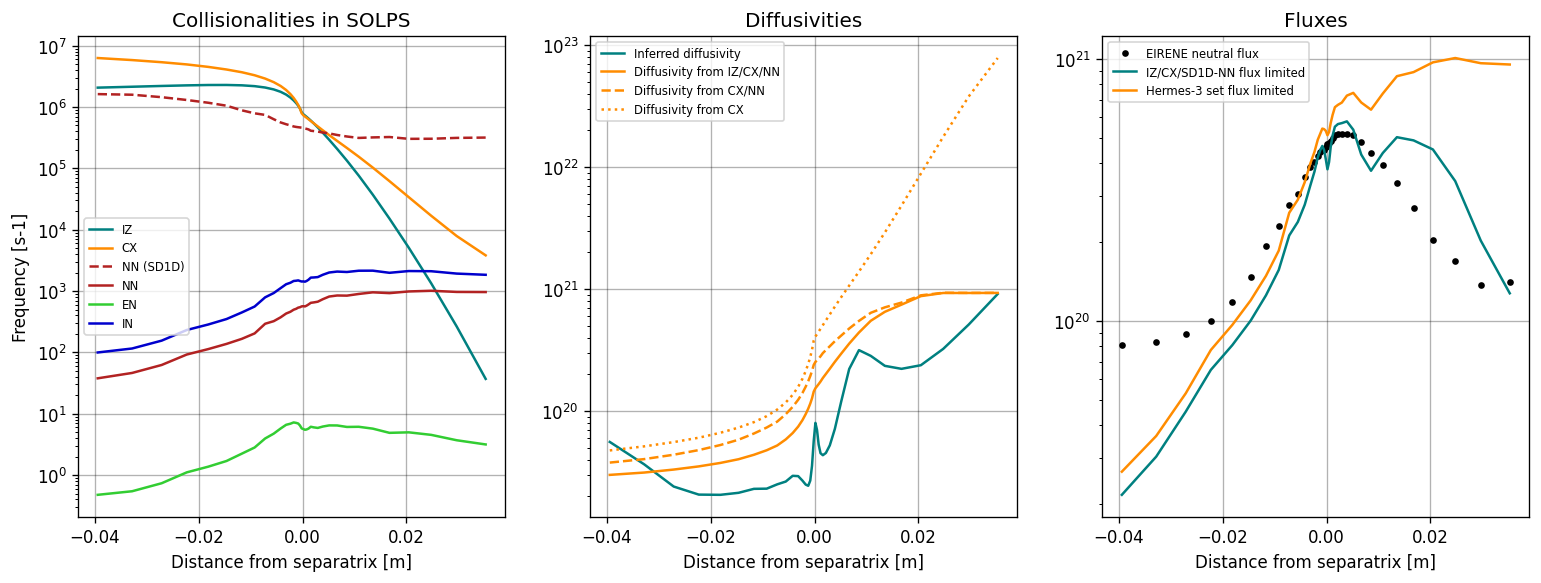

In [97]:
# NN (SD1D) ----------------
nu_nn_sd1d = coll_nn_sd1d(Ta, Na)

# NN ----------------
a0 = np.pi * (2.8e-10)**2   # AKA 2.5e-19
vrel = np.sqrt(2 * constants("q_e") * Ta/(constants("mass_p")*2))
nu_nn = vrel * Na *  a0

# EN ----------------
a0 = 5e-19
vth_e = np.sqrt( (constants("mass_p")/constants("mass_e")) * Te)
nu_en = vth_e * Na * a0

# IN ----------------
a0 = 5e-19
vrel = np.sqrt(constants("q_e") * (Ta + Ti)/(constants("mass_p")*2))
nu_in = vrel * Na * a0

sDn_cx =  1/((nu_cx) * constants("mass_p")*2)
sDn_izcx =  1/((nu_cx + nu_iz) * constants("mass_p")*2)
sDn_cxnn =  1/((nu_cx + nu_nn_sd1d) * constants("mass_p")*2)
sDn_izcxnn =  1/((nu_cx + nu_iz + nu_nn_sd1d) * constants("mass_p")*2)

sDn_hermes =  1/((nu_cx + nu_nn + nu_in + nu_en) * constants("mass_p")*2)
sDn_all =  1/((nu_iz + nu_cx + nu_nn + nu_in + nu_en) * constants("mass_p")*2)

flux = sdata["rfluxa3da"].iloc[1:-1]
sDn_effective = flux / grad_sPa_smooth

def flux_limiter(flux, gamma=1, alpha=1):
    return flux * (1+ (flux / (alpha*flim))**gamma)**(-1/gamma)
    
flux_sDn_hermes = sDn_hermes * grad_sPa_smooth
flux_sDn_all = sDn_all * grad_sPa_smooth
flux_sDn_izcxnn = sDn_izcxnn * grad_sPa_smooth
flux_sDn_izcx = sDn_izcx * grad_sPa_smooth
flux_sDn_cxnn = sDn_cxnn * grad_sPa_smooth
flux_sDn_cx = sDn_cx * grad_sPa_smooth

# Flux limiter
gamma = 1
alpha = 1
flim = Na * 1/4 * np.sqrt( (8*Ta * constants("q_e")) / (np.pi * constants("mass_p")*2) )
def limiter(flux, gamma, alpha):
    return flux * (1+ (flux / (alpha*flim))**gamma)**(-1/gamma)

scale = 1.3
fig, axes = plt.subplots(1,3, figsize=(12*scale,4*scale), dpi = 120)

axes[0].plot(dist, nu_iz, color = "teal", label = "IZ")
axes[0].plot(dist, nu_cx, color = "darkorange", label = "CX")
axes[0].plot(dist, nu_nn_sd1d, color = "firebrick", label = "NN (SD1D)", ls = "--")
axes[0].plot(dist, nu_nn, color = "firebrick", label = "NN")
axes[0].plot(dist, nu_en, color = "limegreen", label = "EN")
axes[0].plot(dist, nu_in, color = "mediumblue", label = "IN")
axes[0].set_ylabel("Frequency [s-1]")
axes[0].set_title("Collisionalities in SOLPS")
axes[0].set_yscale("log")

axes[1].plot(dist, sDn_effective, color = "teal", label = "Inferred diffusivity")
axes[1].plot(dist, sDn_izcxnn, color = "darkorange", label = "Diffusivity from IZ/CX/NN")
axes[1].plot(dist, sDn_cxnn, color = "darkorange", ls = "--", label = "Diffusivity from CX/NN")
axes[1].plot(dist, sDn_cx, color = "darkorange", ls = ":", label = "Diffusivity from CX")
axes[1].set_title("Diffusivities")
axes[1].set_yscale("log")

axes[2].plot(dist, flux, color = "black", marker = "o", lw = 0, ms = 3, label = "EIRENE neutral flux")
axes[2].plot(dist, limiter(flux_sDn_izcxnn, 1,1), color = "teal", label = "IZ/CX/SD1D-NN flux limited")
# axes[2].plot(dist, flux_sDn_all, color = "darkorange", ls = "dashdot", label = "All collisions")
axes[2].plot(dist, limiter(flux_sDn_hermes, 1,1), color = "darkorange", ls = "-", label = "Hermes-3 set flux limited")
# axes[2].plot(dist, flux_sDn_izcx, color = "darkorange", ls = ":", label = "CX/IZ only")

axes[2].set_title("Fluxes")
axes[2].set_yscale("log")



# axes[1].set_yscale("log")
for ax in  axes:
    ax.set_xlabel("Distance from separatrix [m]")
    ax.grid(color = "k", alpha = 0.3)
    ax.legend(fontsize=7)

## Try making limiter isotropic

Text(0.5, 1.0, 'Influence of isotropic limiter on IZ/CX/NN-SD1D set')

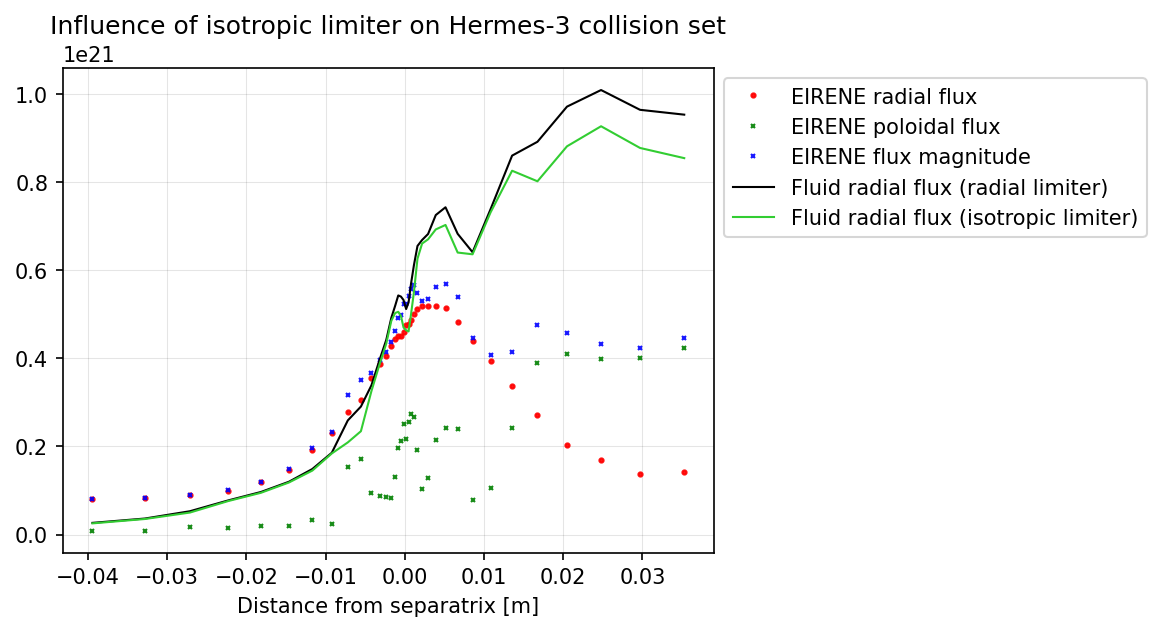

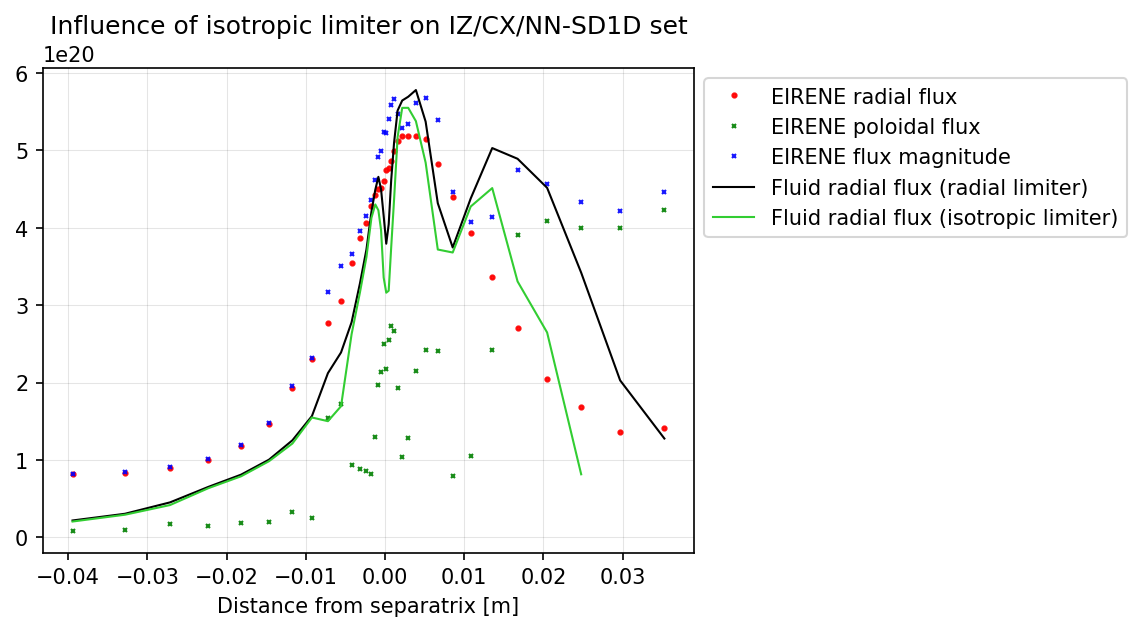

In [102]:
fluxr = sdata["rfluxa3da"].iloc[1:-1]
fluxp = sdata["pfluxa3da"].iloc[1:-1]
fluxm = np.sqrt(fluxr**2 + fluxp**2)

# Flux limiter
gamma = 1
alpha = 1
flim = Na * 1/4 * np.sqrt( (8*Ta * constants("q_e")) / (np.pi * constants("mass_p")*2) )
flim_ion = Na * 1/4 * np.sqrt( (8*Ti * constants("q_e")) / (np.pi * constants("mass_p")*2) )
def limiter(flux, gamma, alpha):
    return flux * (1+ (flux / (alpha*flim))**gamma)**(-1/gamma)

def isolimiter(flux, gamma, alpha):
    flux_mag = np.sqrt(flux**2 + fluxp**2)
    flux_mag_lim = flux_mag * (1+ (flux_mag / (alpha*flim))**gamma)**(-1/gamma)
    flux_rad_lim = np.sqrt(flux_mag_lim**2 - fluxp**2)
    return flux_rad_lim

lw = 0; ms = 2; alpha = 0.9
scale = 0.7
fig, ax = plt.subplots(figsize=(8*scale,6*scale), dpi = 150)
ax.plot(dist, fluxr, color = "red", label = "EIRENE radial flux", lw = lw, alpha = alpha, marker = "o", markersize = ms)
ax.plot(dist, fluxp, color = "green", label = "EIRENE poloidal flux", lw = lw, alpha = alpha, marker = "x", markersize = ms)
ax.plot(dist, fluxm, color = "blue", label = "EIRENE flux magnitude", lw = lw, alpha = alpha, marker = "x", markersize = ms)
# ax.plot(dist, flim, color = "grey", ls = "-", label = "Flux limit", lw = 3, alpha = 0.4)
ax.plot(dist, limiter(flux_sDn_hermes, 1,1), color = "black", label = "Fluid radial flux (radial limiter)", lw = 1)
ax.plot(dist, isolimiter(flux_sDn_hermes, 1,1), color = "limegreen", label = "Fluid radial flux (isotropic limiter)", lw = 1)
# ax.plot(dist, limiter(3,1), color = "firebrick", label = "gamma3, alpha1", lw = 1)
# ax.plot(dist, limiter(1,0.5), color = "darkorange", label = "gamma2, alpha1", lw = 1)
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
# ax.set_yscale("log")
ax.grid(which="both", c = "k", alpha = 0.1, lw = 0.5)
ax.set_xlabel("Distance from separatrix [m]")
ax.set_title("Influence of isotropic limiter on Hermes-3 collision set")

fig, ax = plt.subplots(figsize=(8*scale,6*scale), dpi = 150)
ax.plot(dist, fluxr, color = "red", label = "EIRENE radial flux", lw = lw, alpha = alpha, marker = "o", markersize = ms)
ax.plot(dist, fluxp, color = "green", label = "EIRENE poloidal flux", lw = lw, alpha = alpha, marker = "x", markersize = ms)
ax.plot(dist, fluxm, color = "blue", label = "EIRENE flux magnitude", lw = lw, alpha = alpha, marker = "x", markersize = ms)
# ax.plot(dist, flim, color = "grey", ls = "-", label = "Flux limit", lw = 3, alpha = 0.4)
ax.plot(dist, limiter(flux_sDn_izcxnn, 1,1), color = "black", label = "Fluid radial flux (radial limiter)", lw = 1)
ax.plot(dist, isolimiter(flux_sDn_izcxnn, 1,1), color = "limegreen", label = "Fluid radial flux (isotropic limiter)", lw = 1)
# ax.plot(dist, limiter(3,1), color = "firebrick", label = "gamma3, alpha1", lw = 1)
# ax.plot(dist, limiter(1,0.5), color = "darkorange", label = "gamma2, alpha1", lw = 1)
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
# ax.set_yscale("log")
ax.grid(which="both", c = "k", alpha = 0.1, lw = 0.5)
ax.set_xlabel("Distance from separatrix [m]")
ax.set_title("Influence of isotropic limiter on IZ/CX/NN-SD1D set")

## Enhance limiter in the core

Text(0.5, 0, 'Distance from separatrix [m]')

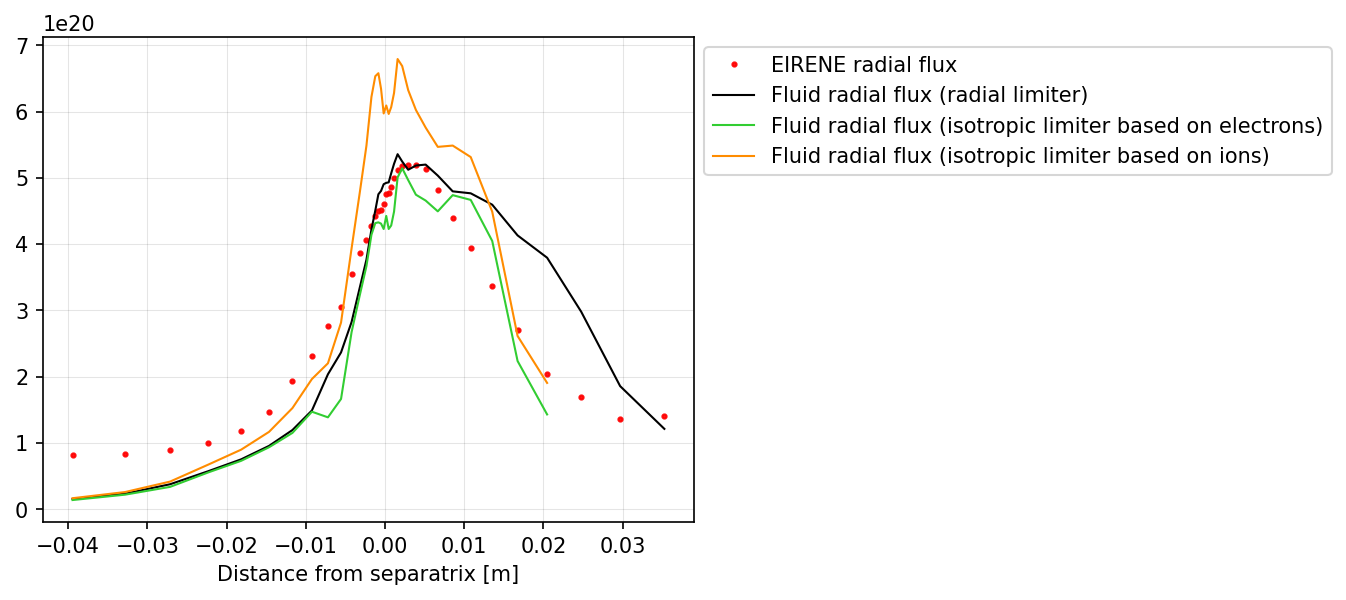

In [75]:
fluxr = sdata["rfluxa3da"].iloc[1:-1]
fluxp = sdata["pfluxa3da"].iloc[1:-1]
fluxm = np.sqrt(fluxr**2 + fluxp**2)

# Flux limiter
gamma = 1
alpha = 1
flim = Na * 1/4 * np.sqrt( (8*Ta * constants("q_e")) / (np.pi * constants("mass_p")*2) )
flim_ion = Na * 1/4 * np.sqrt( (8*Ti * constants("q_e")) / (np.pi * constants("mass_p")*2) )
def limiter(gamma, alpha):
    return flux_sDn_izcxnn * (1+ (flux_sDn_izcxnn / (alpha*flim))**gamma)**(-1/gamma)

def isolimiter(gamma, alpha, flim):
    flux_mag = np.sqrt(flux_sDn_izcxnn**2 + fluxp**2)
    flux_mag_lim = flux_mag * (1+ (flux_mag / (alpha*flim))**gamma)**(-1/gamma)
    flux_rad_lim = np.sqrt(flux_mag_lim**2 - fluxp**2)
    return flux_rad_lim

lw = 0; ms = 2; alpha = 0.9
scale = 0.7
fig, ax = plt.subplots(figsize=(8*scale,6*scale), dpi = 150)
ax.plot(dist, fluxr, color = "red", label = "EIRENE radial flux", lw = lw, alpha = alpha, marker = "o", markersize = ms)
# ax.plot(dist, fluxp, color = "green", label = "EIRENE poloidal flux", lw = lw, alpha = alpha, marker = "x", markersize = ms)
# ax.plot(dist, fluxm, color = "blue", label = "EIRENE flux magnitude", lw = lw, alpha = alpha, marker = "x", markersize = ms)
# ax.plot(dist, flim, color = "grey", ls = "-", label = "Flux limit", lw = 3, alpha = 0.4)
ax.plot(dist, limiter(1,1), color = "black", label = "Fluid radial flux (radial limiter)", lw = 1)
ax.plot(dist, isolimiter(1,1, flim = flim), color = "limegreen", label = "Fluid radial flux (isotropic limiter based on electrons)", lw = 1)
ax.plot(dist, isolimiter(1,1, flim = flim_ion), color = "darkorange", label = "Fluid radial flux (isotropic limiter based on ions)", lw = 1)
# ax.plot(dist, limiter(3,1), color = "firebrick", label = "gamma3, alpha1", lw = 1)
# ax.plot(dist, limiter(1,0.5), color = "darkorange", label = "gamma2, alpha1", lw = 1)
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
# ax.set_yscale("log")
ax.grid(which="both", c = "k", alpha = 0.1, lw = 0.5)
ax.set_xlabel("Distance from separatrix [m]")

# Plot Ti/Ta ratio
# ax2 = ax.twinx()
# ax2.plot(dist, Ti/Ta)

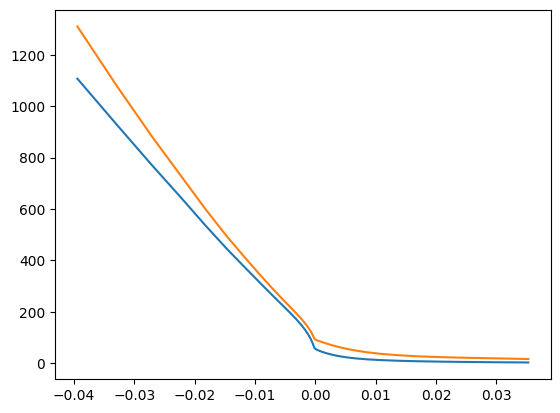

In [66]:
plt.plot(dist, Te)
plt.plot(dist, Ti)

Text(0.5, 0, 'Distance from separatrix [m]')

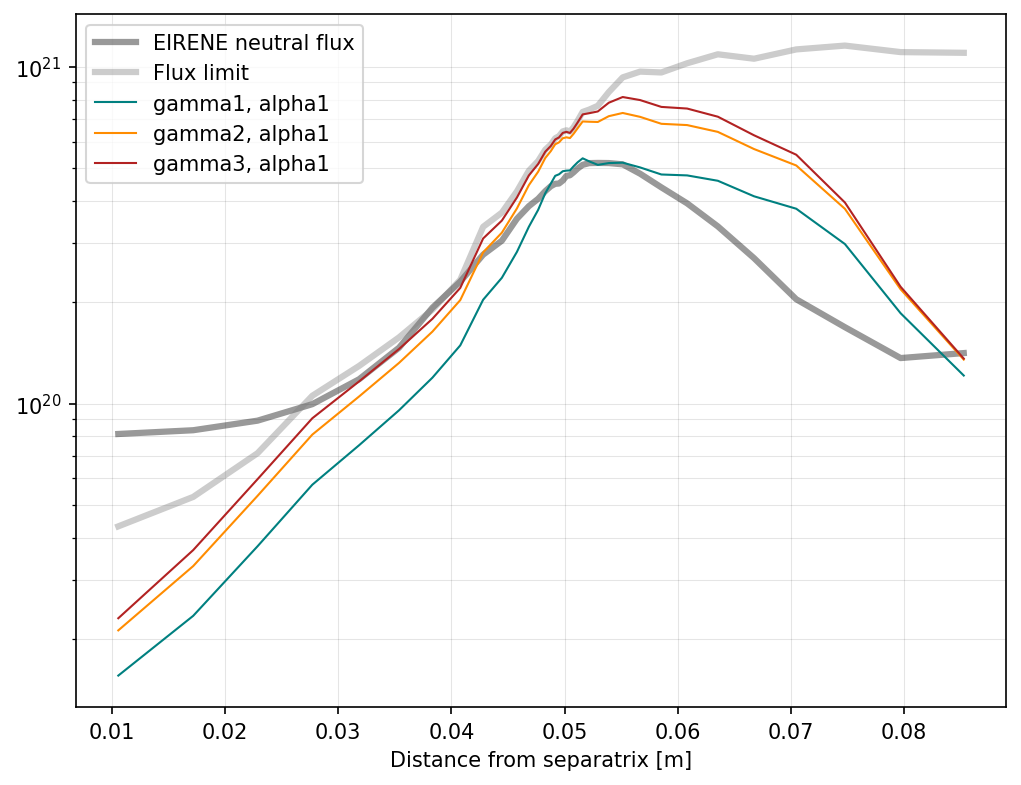

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), dpi = 150)
ax.plot(dist, flux, color = "black", label = "EIRENE neutral flux", lw = 3, alpha = 0.4)
ax.plot(dist, flim, color = "grey", ls = "-", label = "Flux limit", lw = 3, alpha = 0.4)
ax.plot(dist, limiter(1,1), color = "teal", label = "gamma1, alpha1", lw = 1)
ax.plot(dist, limiter(2,1), color = "darkorange", label = "gamma2, alpha1", lw = 1)
ax.plot(dist, limiter(3,1), color = "firebrick", label = "gamma3, alpha1", lw = 1)
# ax.plot(dist, limiter(1,0.5), color = "darkorange", label = "gamma2, alpha1", lw = 1)
ax.legend()
ax.set_yscale("log")
ax.grid(which="both", c = "k", alpha = 0.1, lw = 0.5)
ax.set_xlabel("Distance from separatrix [m]")

# Hermes-3 limiter

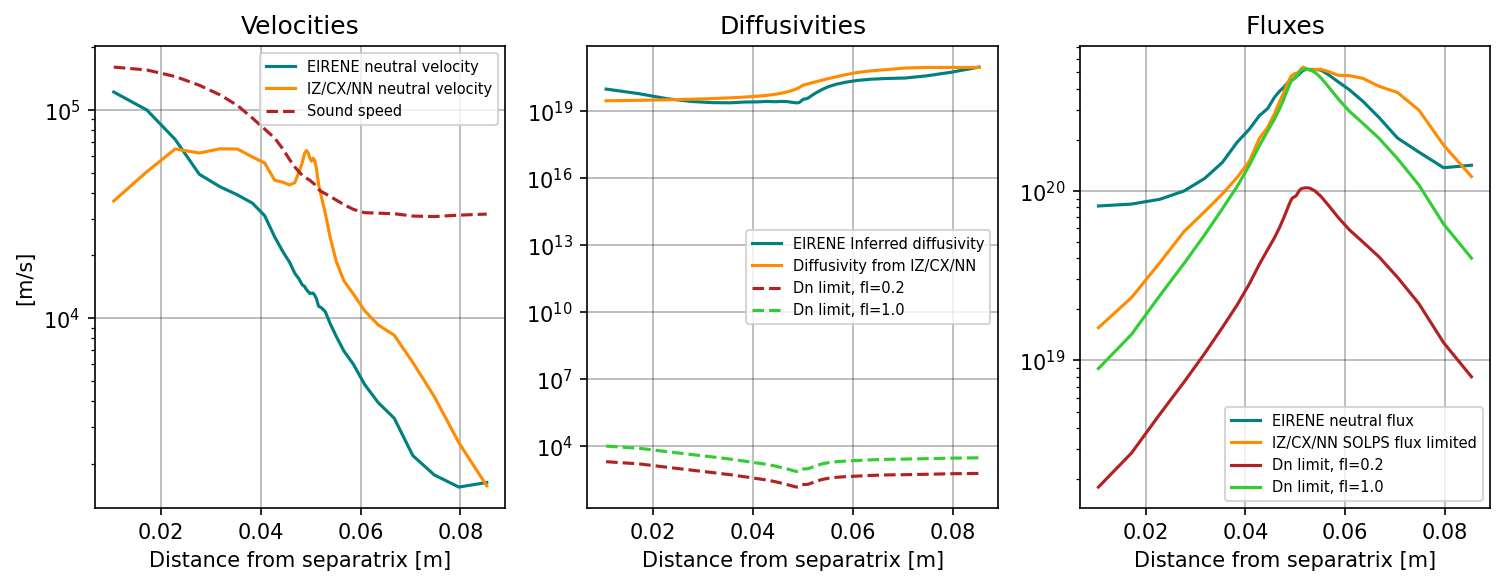

In [152]:
fig, axes = plt.subplots(1,3, figsize=(12,4), dpi = 150)

Vd = flux / Na
Vd_izcxnn = flux_sDn_izcxnn / Na

neutral_lmax = 0.1   # Maximum mfp 
cs = np.sqrt(Ta_smooth * constants("q_e") / (constants("mass_p")*2))
# dmax = 1 * cs / (abs((np.gradient(np.log(sPa), dist))) + 1/neutral_lmax)

# hlimited = actual hermes-3 limiter approach
def hlimit_Dn(alpha, neutral_lmax):
    Dn_max = alpha  * cs / (abs((np.gradient(np.log(sPa_smooth), dist))) + 1/neutral_lmax)
    sDn_hlimited = np.clip(sDn_izcxnn, None, Dn_max)
    return sDn_hlimited

sDn_hlimited_default = hlimit_Dn(0.2, 0.1)
sDn_hlimited_unity = hlimit_Dn(1, 0.1)

flux_sDn_hlimited_default = sDn_hlimited_default * grad_sPa_smooth * Na_smooth
flux_sDn_hlimited_unity = sDn_hlimited_unity * grad_sPa_smooth * Na_smooth

axes[0].plot(dist, Vd, color = "teal", label = "EIRENE neutral velocity")
axes[0].plot(dist, Vd_izcxnn, color = "darkorange", label = "IZ/CX/NN neutral velocity")
axes[0].plot(dist, cs, color = "firebrick", label = "Sound speed", ls = "--")

# axes[0].plot(dist, nu_nn, color = "firebrick", label = "NN")
axes[0].set_ylabel("[m/s]")
axes[0].set_title("Velocities")
axes[0].set_yscale("log")

axes[1].plot(dist, sDn_effective, color = "teal", label = "EIRENE Inferred diffusivity")
axes[1].plot(dist, sDn_izcxnn, color = "darkorange", label = "Diffusivity from IZ/CX/NN")
axes[1].plot(dist, dmax_default_fl, color = "firebrick", ls = "--", label = "Dn limit, fl=0.2")
axes[1].plot(dist, dmax_unity_fl, color = "limegreen", ls = "--", label = "Dn limit, fl=1.0")
# axes[1].plot(dist, sDn_cx, color = "darkorange", ls = ":", label = "Diffusivity from CX")
axes[1].set_title("Diffusivities")
axes[1].set_yscale("log")

axes[2].plot(dist, flux, color = "teal", label = "EIRENE neutral flux")
axes[2].plot(dist, limiter(1,1), color = "darkorange", label = "IZ/CX/NN SOLPS flux limited")
axes[2].plot(dist, flux_sDn_hlimited_default, color = "firebrick", label = "Dn limit, fl=0.2")
axes[2].plot(dist, flux_sDn_hlimited_unity, color = "limegreen", label = "Dn limit, fl=1.0")
# axes[2].plot(dist, flux_sDn_izcxnn, color = "darkorange", ls = "dashdot", label = "IZ/CX/NN")
# axes[2].plot(dist, flux_sDn_cxnn, color = "darkorange", ls = "--", label = "CX/NN")
# axes[2].plot(dist, flux_sDn_cx, color = "darkorange", ls = ":", label = "CX")
# axes[2].plot(dist, flux_sDn_hlimited, color = "firebrick", ls = ":", label = "IZ/CX/NN Hermes-3 limited")

axes[2].set_title("Fluxes")
axes[2].set_yscale("log")

for ax in  axes:
    ax.set_xlabel("Distance from separatrix [m]")
    ax.grid(color = "k", alpha = 0.3)
    ax.legend(fontsize=7)

Text(0.5, 0, 'Distance from separatrix [m]')

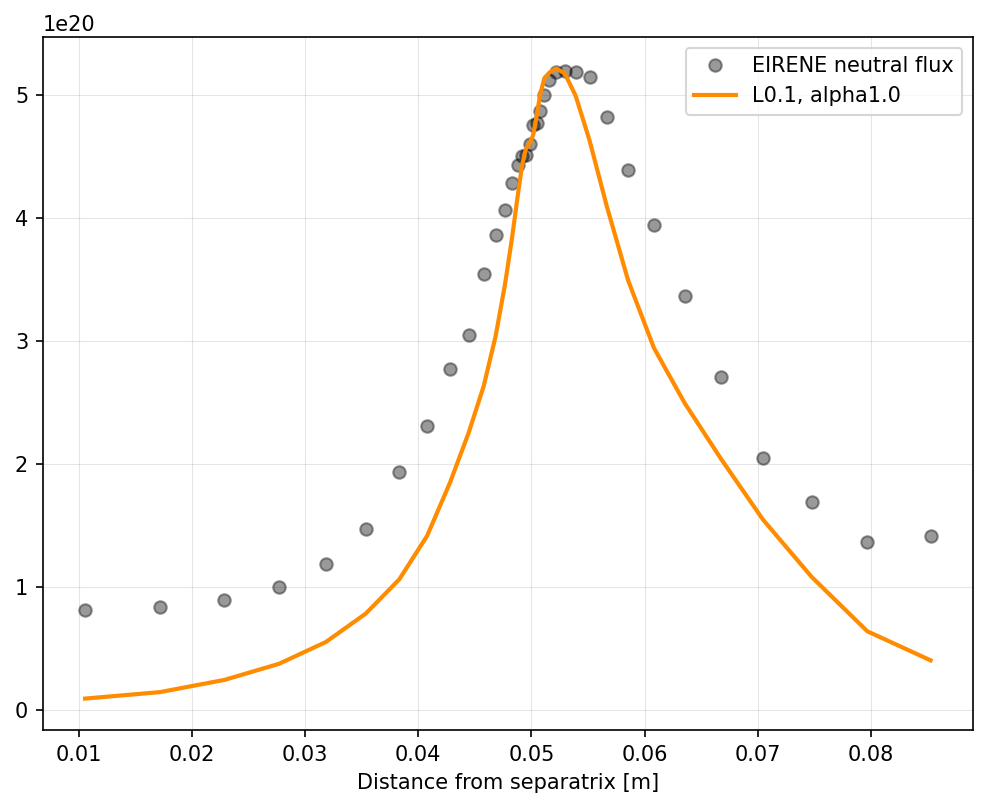

In [156]:
sDn_hlimited_default = hlimit_Dn(0.2, 0.1)
sDn_hlimited_unity = hlimit_Dn(1, 0.1)
sDn_hlimited_unity = hlimit_Dn(1, 0.1)

flux_sDn_hlimited_default = sDn_hlimited_default * grad_sPa_smooth * Na_smooth
flux_sDn_hlimited_unity = sDn_hlimited_unity * grad_sPa_smooth * Na_smooth

fig, ax = plt.subplots(figsize=(8,6), dpi = 150)
ax.plot(dist, flux, color = "black", label = "EIRENE neutral flux", lw = 0, alpha = 0.4, marker = "o")
# ax.plot(dist, flim, color = "grey", ls = "-", label = "Flux limit", lw = 3, alpha = 0.4)
# ax.plot(dist, flux_sDn_hlimited_default, color = "teal", label = "L0.1, alpha0.2", lw = 2)
ax.plot(dist, flux_sDn_hlimited_unity, color = "darkorange", label = "L0.1, alpha1.0", lw = 2)
# ax.plot(dist, hlimit_Dn(1, 0.1) * grad_sPa_smooth * Na_smooth, color = "firebrick", label = "LXX, alpha1.0", lw = 2)
# ax.plot(dist, limiter(3,1), color = "firebrick", label = "gamma3, alpha1", lw = 1)
# ax.plot(dist, limiter(1,0.5), color = "darkorange", label = "gamma2, alpha1", lw = 1)
ax.legend()
# ax.set_yscale("log")
ax.grid(which="both", c = "k", alpha = 0.1, lw = 0.5)
ax.set_xlabel("Distance from separatrix [m]")

# Part II: More detail + SOLEDGE2D

In [34]:
from soledge.wrapper_class import *
slc = SOLEDGEcase(r"C:\Users\mikek\OneDrive\Project\collab\Hermes-3 Comparison Shared\completed_runs\ST40_wallMike_bra_nocore_D_2e19")
# slc = SOLEDGEcase(r"C:\Users\mikek\OneDrive\Project\collab\Hermes-3 Comparison Shared\completed_runs\ST40_wallStd_bra_nocore_D_2e19")


c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


### Get data

In [35]:
dfs = []

dist = slc.get_1d_radial_data("Dense")["dist"].values
Ne = slc.get_1d_radial_data("Dense")["Dense"].values
Na = slc.get_1d_radial_data("Nni")["Nni"].values
Te = slc.get_1d_radial_data("Tempe")["Tempe"].values
Ta = slc.get_1d_radial_data("Tni")["Tni"].values
Vxa = slc.get_1d_radial_data("vxni")["vxni"].values
Vya = slc.get_1d_radial_data("vyni")["vyni"].values
Vza = slc.get_1d_radial_data("vzni")["vzni"].values
Pa = Na * Ta * constants("q_e") * 3/2
flux = Na * Vxa   # m-2s-1

### Pressure gradient

In [36]:
plt.close("all")
%matplotlib inline

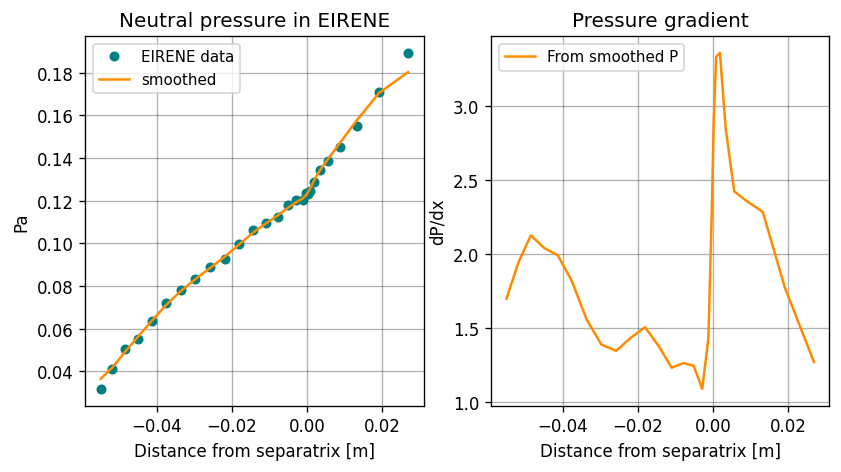

In [44]:
from sd1d.analysis import AMJUEL
rtools = AMJUEL()

def smooth(x,w,recursion=0):
    out = scipy.ndimage.gaussian_filter(x, w)
    for i in range(recursion):
        out = scipy.ndimage.gaussian_filter(out, w)
    return out

fig, axes = plt.subplots(1,2, figsize=(8,4), dpi = 120)

Pa_smooth = smooth(Pa,0.5, recursion=5)
grad_Pa = np.gradient(dist, Pa)
grad_Pa_smooth = np.gradient(Pa_smooth, dist)

axes[0].plot(dist, Pa, color = "teal", lw = 0, marker = "o", ms = 5, label = "EIRENE data")
axes[0].plot(dist, Pa_smooth, color = "darkorange", label = "smoothed")
axes[0].set_ylabel("Pa")
axes[0].set_title("Neutral pressure in EIRENE")
# axes[1].plot(dist, grad_Pa, color = "teal", label = "EIRENE raw data")
axes[1].plot(dist, grad_Pa_smooth, color = "darkorange", label = "From smoothed P")
axes[1].set_ylabel("dP/dx")
axes[1].set_title("Pressure gradient")


for ax in  axes:
    ax.set_xlabel("Distance from separatrix [m]")
    ax.grid(color = "k", alpha = 0.3)
    ax.legend(fontsize=9)
    # ax.set_xlim(None, 0.045)

In [155]:
Ne * Te 

array([8.21729129e+22, 6.69431913e+22, 5.42507403e+22, 4.39020603e+22,
       3.49384129e+22, 2.76914516e+22, 2.19861678e+22, 1.73108552e+22,
       1.35357770e+22, 1.05449600e+22, 8.19416123e+21, 6.35181142e+21,
       4.92178562e+21, 3.83939515e+21, 3.02158760e+21, 2.36686451e+21,
       1.78986444e+21, 1.21063392e+21, 1.03804203e+21, 9.50992245e+20,
       8.69363411e+20, 7.84777782e+20, 6.91265095e+20, 5.87919285e+20,
       4.78771821e+20, 3.71276137e+20, 2.73972793e+20, 1.92435470e+20,
       1.28064124e+20, 7.99108142e+19, 4.58904145e+19, 2.39717241e+19,
       1.13675438e+19, 4.90351993e+18, 1.95767040e+18, 7.95678653e+17])

In [45]:
fun = scipy.interpolate.UnivariateSpline(sdata.index, sPa)
fun(1
    )

array(nan)

# Radial flux analysis

In [58]:
def makeflux(ds):
    omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    area_yz = omp["J"] * omp["g11"]
    hflux = omp["pf_perp_diff_R_d"] / area_yz
    return hflux

def makehflux(ds):
    omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    area_yz = omp["J"] * omp["g11"]
    hflux = omp["hf_perp_diff_R_d"] / area_yz
    return hflux

omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

KeyError: 'pf_perp_diff_R_d'

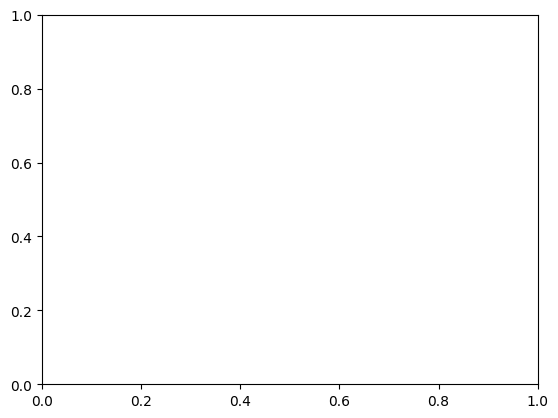

In [59]:
fig, ax = plt.subplots()
ax.plot(dist, -1*(makeflux(casestore["1e19"].ds)), label = "Hermes-3: 1e19", color = "#2b83ba", lw=2)
ax.plot(dist, -1*(makeflux(casestore["2e19"].ds)), label = "Hermes-3: 2e19", color = "darkorange", lw=2)
ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["rfluxa3da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["rfluxa3da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Radial neutral transport")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("Radial neutral flux [m-2s-1]")

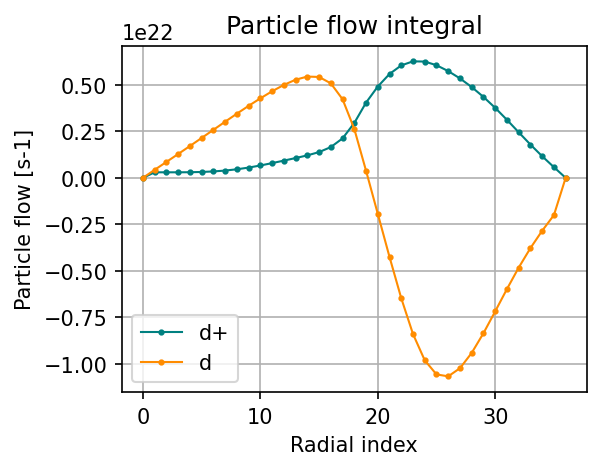

In [16]:
plot_perp_particle_fluxes(ds.isel(t=-1))